#### Importing the model and getting the output values of the pep-encoder

##### Setting up the constants and imports:

In [110]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from modelAndPerformances import *
import seaborn as sns

# Device setup
device = "cpu"
# Load model hyperparameters and data
d_model = 64
d_ff = 768
d_k = 32
n_layers = 3
n_heads = 1
dropout = 0.1

#### Using some guidelines for good plots settings from a course at Imperial

In [ ]:
## Code from Methods for Data Science guide for plotting at Imperial College London for settings
# we define a mix of fontsizes, for different parts of a plot
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

# example of how you can use these fontsizes to set a global configuration for matplotlib;
# you should assign them based on the specific appearance of the figures you are producing
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#setting seeds
seed = 6
random.seed(seed )
torch.manual_seed(seed )
np.random.seed(seed ) 

##### Setting up required masks and making data smaller (more maneagable)

In [ ]:
data = pd.read_csv('data/testData/testData.csv')
pep_inputs, hla_inputs, labels, labelsHla = make_data(data, True)

# Filter only positive labels
positive_mask = labels == 1
pep_pos = pep_inputs[positive_mask]
hla_pos = hla_inputs[positive_mask]
labels_pos = labels[positive_mask]
labelsHla_pos = labelsHla[positive_mask] 

# Get a unique list of all HLA alleles
unique_hlas = list(set(labelsHla_pos))

# Randomly select 5 HLA alleles
random_hlas = random.sample(unique_hlas, 5)
selected_hlas = random_hlas
print(f"Selected HLA alleles: {selected_hlas}")
# Add peptide strings to the lists too
pep_pos_seq = np.array(data.peptide)[positive_mask]

pep_list = []
hla_list = []
labels_list = []
labelsHla_list = []
pep_seq_list = []  

for hla in selected_hlas:
    hla_mask = labelsHla_pos == hla

    pep_hla = pep_pos[hla_mask]
    hla_hla = hla_pos[hla_mask]
    labels_hla = labels_pos[hla_mask]
    labelsHla_hla = labelsHla_pos[hla_mask]
    pep_seq_hla = pep_pos_seq[hla_mask]  

    num_samples_hla = 200
    indices = torch.randperm(len(pep_hla))[:num_samples_hla]

    pep_list.append(pep_hla[indices])
    hla_list.append(hla_hla[indices])
    labels_list.append(labels_hla[indices])
    labelsHla_list.append(labelsHla_hla[indices])
    pep_seq_list.append(pep_seq_hla[indices]) 
     
pepSmall = torch.cat(pep_list).to(device)
hlaSmall = torch.cat(hla_list).to(device)
labelsSmall = torch.cat(labels_list)
labelsSmallHla = np.concatenate(labelsHla_list)
pepSmallSeq = np.concatenate(pep_seq_list)



Selected HLA alleles: [np.str_('HLA-A*11:02'), np.str_('HLA-B*27:09'), np.str_('HLA-B*15:03'), np.str_('HLA-C*06:02'), np.str_('HLA-C*12:02')]


##### Make hook to store pep_encoder information

In [113]:
# Load model
model = Transformer(d_model, d_k, n_layers, n_heads, d_ff, dropout=dropout)
model.load_state_dict(torch.load("model/best_model_final.pt", map_location=device))
model.to(device)
model.eval()

# Hook to extract encoder outputs
pepEncoderOutputs = {}
def get_activation(name):
    def hook(model, input, output):
        pepEncoderOutputs["pep"] = output[0].detach()
    return hook

model.pep_encoder.register_forward_hook(get_activation("pep_encoder"))

# Forward pass
model(pepSmall, hlaSmall)
pepEncoderOutputs = pepEncoderOutputs["pep"]  


##### Make hook to store decoder information

In [114]:
# Extract encoder outputs using forward hook
decOutputs = {}

def get_activation(name):
    def hook(model, input, output):
        decOutputs["dec"] = output[0].detach()
    return hook
# Load and prepare model
model = Transformer(d_model, d_k, n_layers, n_heads, d_ff)
model.load_state_dict(torch.load("model/best_model_final.pt", map_location=device))
model.to(device)
model.eval()
model.decoder.register_forward_hook(get_activation("decoder"))

# Forward pass
model(pepSmall, hlaSmall)
decOutputs = decOutputs["dec"]


##### Prepare both for plotting

In [ ]:
# Average over sequence dimension
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
decOutputs = decOutputs[:, :46, :]
pepEncoderOutputs = torch.flatten(pepEncoderOutputs, -2)
decOutputs = torch.flatten(decOutputs, -2)
reducer3d = umap.UMAP(n_components=3)
reducer2d = umap.UMAP(n_components=2)

encoderUmap2d = reducer2d.fit_transform(pepEncoderOutputs)
encoderUmap3d = reducer3d.fit_transform(pepEncoderOutputs)

decoderUmap2d = reducer2d.fit_transform(decOutputs)
decoderUmap3d = reducer3d.fit_transform(decOutputs)

# Cluster with DBSCAN 
dbscan = DBSCAN(eps=0.3, min_samples=10)  
cluster_labels = dbscan.fit_predict(encoderUmap2d)

# Find the largest cluster (ignoring noise, label = -1)
unique, counts = np.unique(cluster_labels, return_counts=True)
mask_non_noise = unique != -1
largest_cluster_label = unique[mask_non_noise][np.argmax(counts[mask_non_noise])]

# Keep only points in the largest cluster
cluster_mask = cluster_labels == largest_cluster_label
encoderUmap2dReduced = encoderUmap2d[cluster_mask]
encoderUmap3dReduced = encoderUmap3d[cluster_mask]
labelsSmallHlaReduced = np.array(labelsSmallHla)[cluster_mask]  

#### Making palette with some imperial colours (and some non imperial colours)

In [116]:
colors = ['#9BC995', "#083D77", '#9A031E', '#C4B7CB', '#FC7753']

# Create a seaborn palette from these colors
custom_palette = sns.color_palette(colors)

#percentage of outliers constant
percentageOfOutliers = 5

#### Dimensionality Reduction via MDS showing Encoder outputs. Using Seaborn

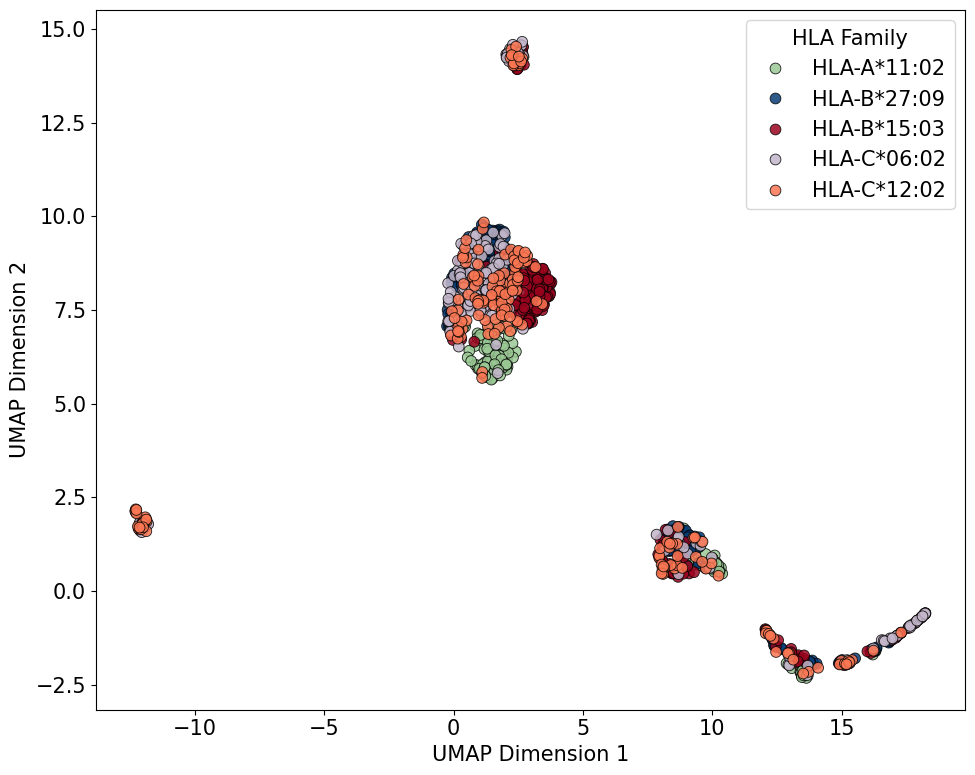

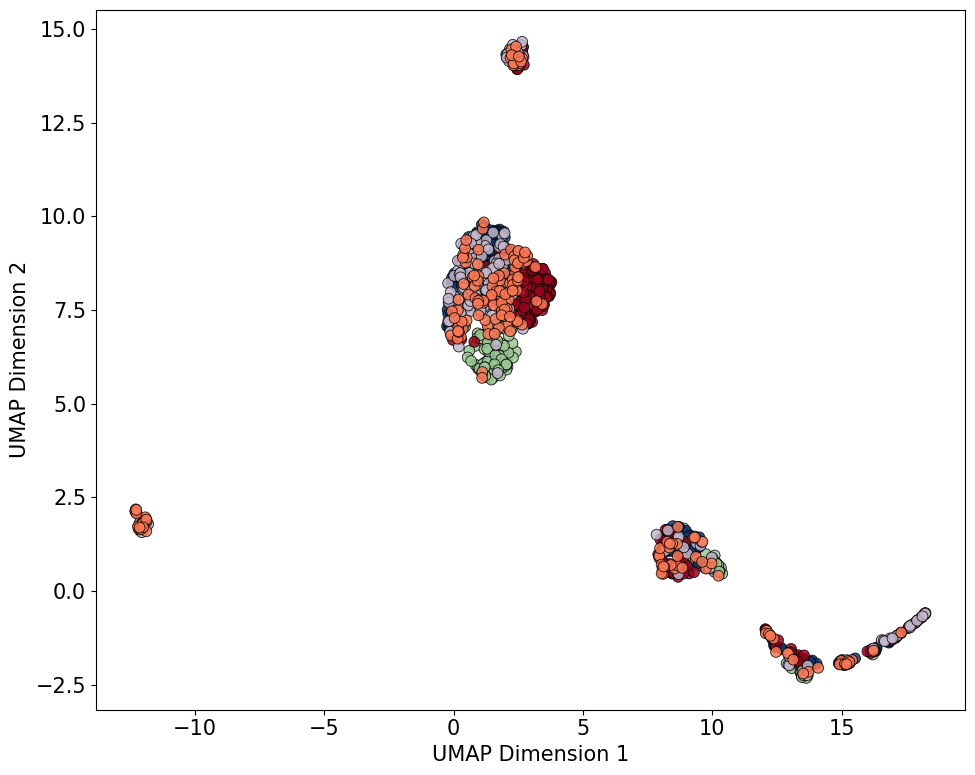

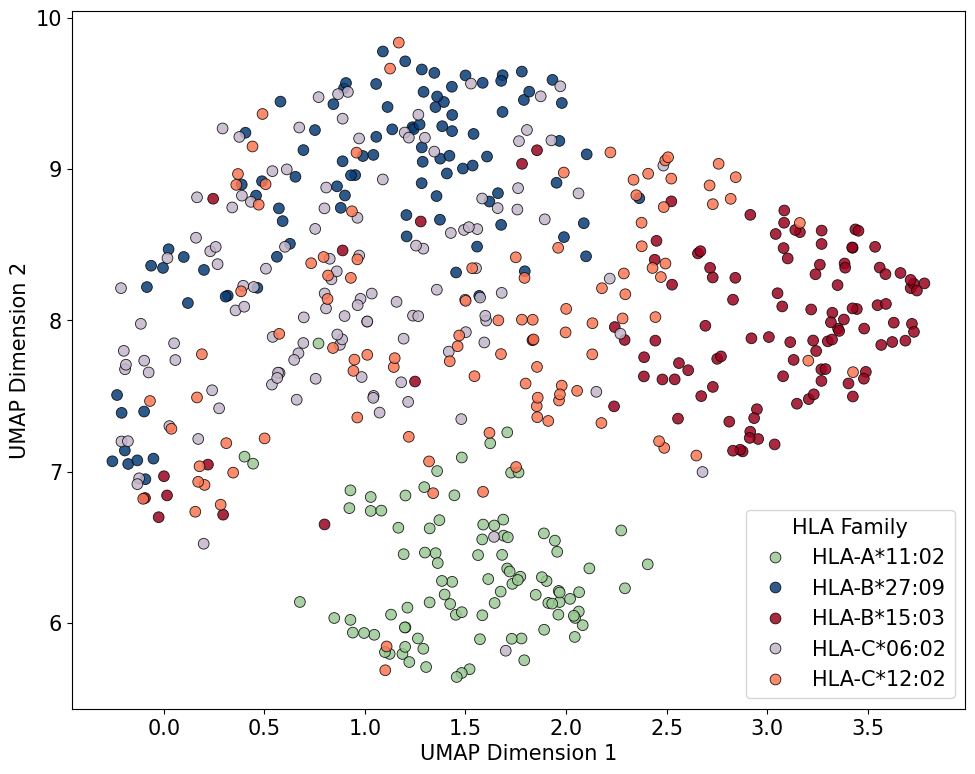

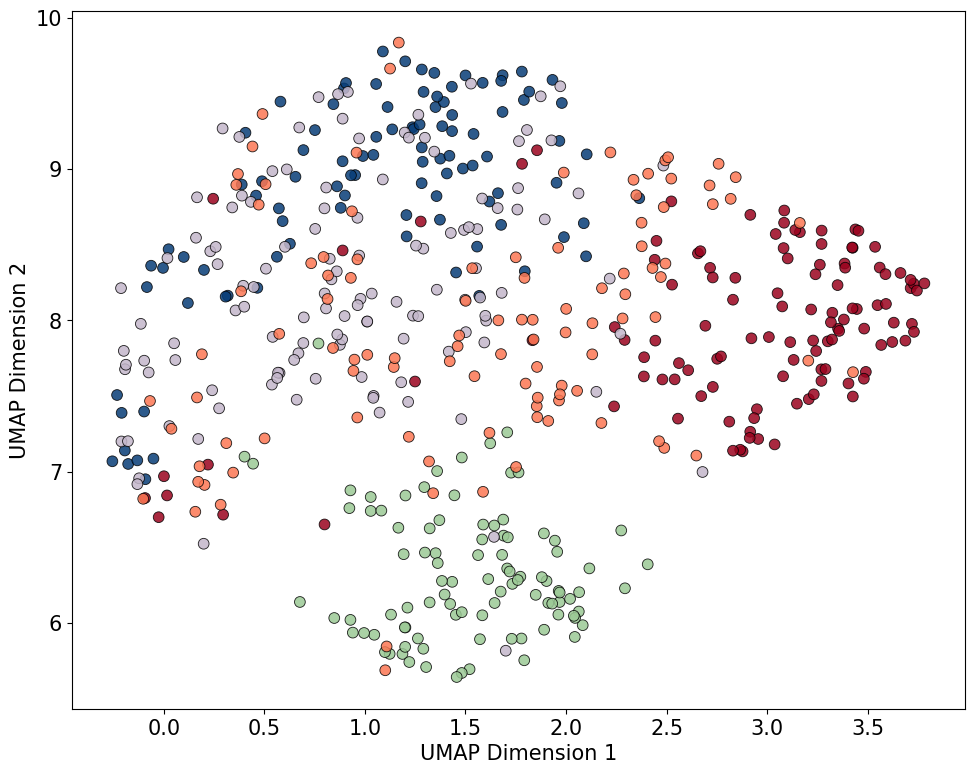

In [127]:
def plot_umap_by_family(embeddingsUMAP, families, title="2D UMAP of Peptide Encodings by HLA Family", show_legend=True, legend="upper right"):
    # Font sizes
    SMALL_SIZE = 15
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 23
    plt.rc('font', size=SMALL_SIZE)
    plt.rc('axes', titlesize=BIGGER_SIZE)
    plt.rc('axes', labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)
    plt.rc('legend', fontsize=MEDIUM_SIZE)
    plt.rc('figure', titlesize=BIGGER_SIZE)

    # Prepare dataframe for seaborn plotting
    df = pd.DataFrame({
        'UMAP1': embeddingsUMAP[:, 0],
        'UMAP2': embeddingsUMAP[:, 1],
        'Family': families
    })

    # Updated: Consistent figure size
    plt.figure(figsize=(10, 8))
    unique_families = df['Family'].unique()
    palette = sns.color_palette(custom_palette, n_colors=len(unique_families))

    sns.scatterplot(
        data=df,
        x='UMAP1', y='UMAP2',
        hue='Family',
        palette=palette,
        edgecolor='k',
        s=60,
        alpha=0.85
    )
    if not show_legend:
        plt.legend([], [], frameon=False)
    else:
        plt.legend(title="HLA Family", loc=legend)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Plot calls for 2D UMAP
plot_umap_by_family(encoderUmap2d, labelsSmallHla, title = "UMAP of Peptide Encoder Output:\n Embeddings by HLA Family", legend = "upper right")
plot_umap_by_family(encoderUmap2d, labelsSmallHla, show_legend=False, title = "UMAP of Peptide Encoder Output:\n Embeddings by HLA Family")
plot_umap_by_family(encoderUmap2dReduced,labelsSmallHlaReduced, title= "UMAP of Peptide Encoder Output (Reduced):\n Embeddings by HLA Family", legend = "lower right")
plot_umap_by_family(encoderUmap2dReduced,labelsSmallHlaReduced, show_legend=False, title= "UMAP of Peptide Encoder Output (Reduced):\n Embeddings by HLA Family", legend = "lower right")

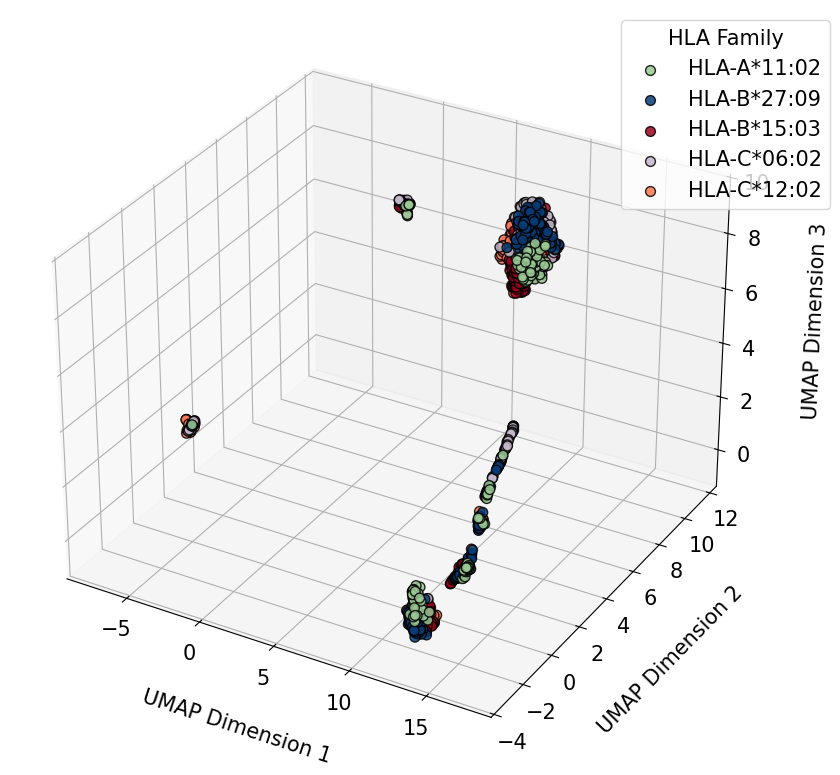

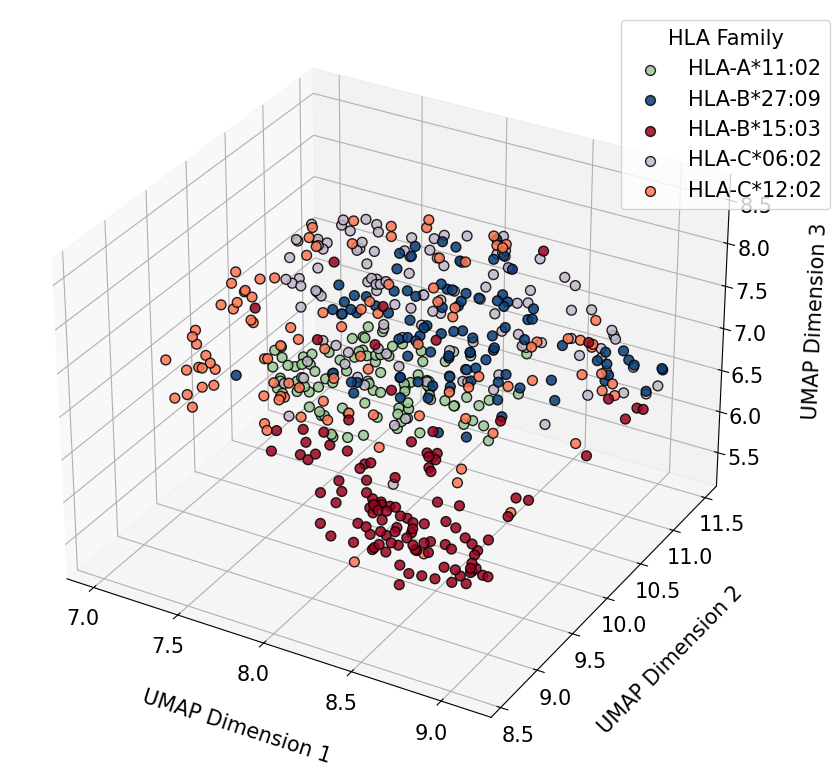

In [128]:
def plot_umap_3d(embeddingsUMAP, families, title="3D UMAP of Peptide Encoding\n by HLA Family"):
    # Font sizes
    SMALL_SIZE = 15
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 20
    plt.rc('font', size=SMALL_SIZE)
    plt.rc('axes', titlesize=BIGGER_SIZE)
    plt.rc('axes', labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)
    plt.rc('legend', fontsize=MEDIUM_SIZE)
    plt.rc('figure', titlesize=BIGGER_SIZE)

    df = pd.DataFrame({
        'UMAP1': embeddingsUMAP[:, 0],
        'UMAP2': embeddingsUMAP[:, 1],
        'UMAP3': embeddingsUMAP[:, 2],
        'Family': families
    })

    unique_families = df['Family'].unique()
    palette = sns.color_palette(custom_palette, n_colors=len(unique_families))
    color_dict = dict(zip(unique_families, palette))

    # Updated: Fixed figure size to ensure both plots are consistent
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for fam in unique_families:
        data_fam = df[df['Family'] == fam]
        ax.scatter(
            data_fam['UMAP1'], data_fam['UMAP2'], data_fam['UMAP3'],
            label=fam,
            color=color_dict[fam],
            edgecolor='k',
            s=50,
            alpha=0.85
        )
    ax.set_xlabel("UMAP Dimension 1", labelpad=20)
    ax.set_ylabel("UMAP Dimension 2", labelpad=20)
    ax.set_zlabel("UMAP Dimension 3", labelpad=20)
    ax.legend(title="HLA Family", bbox_to_anchor=(1.1, 1), fontsize=SMALL_SIZE)
    plt.tight_layout()
    plt.show()

# Plot calls for 3D UMAP
plot_umap_3d(encoderUmap3d,labelsSmallHla, title= "3D UMAP of Peptide Encoder Output:\n Embeddings by HLA Family")
plot_umap_3d(encoderUmap3dReduced,labelsSmallHlaReduced, title= "3D UMAP of Peptide Encoder Output (Reduced):\n Embeddings by HLA Family")

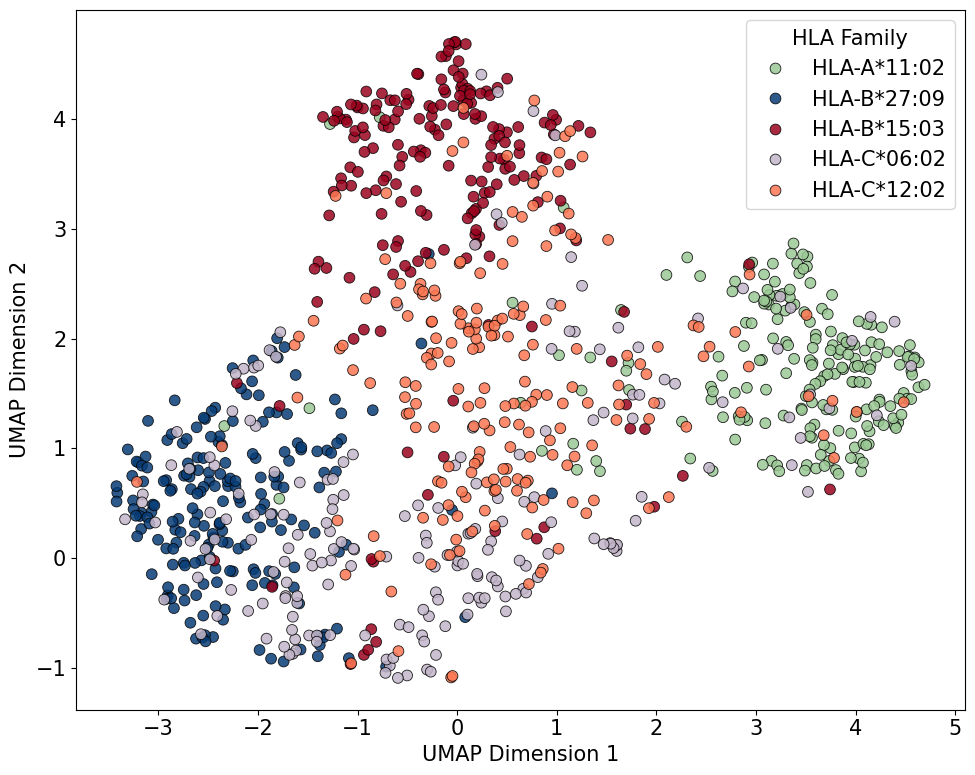

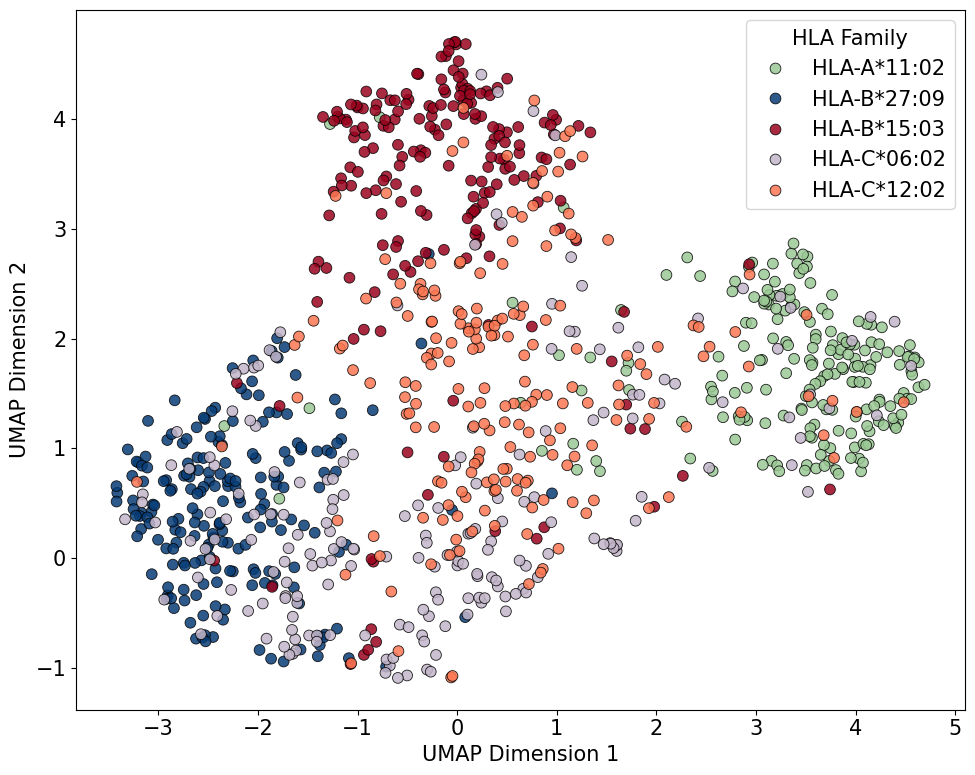

In [129]:
plot_umap_by_family(decoderUmap2d,labelsSmallHla, title= "UMAP of Final Encoder Output:\n Peptide Embeddings by HLA Family", legend = "upper right")
plot_umap_by_family(decoderUmap2d,labelsSmallHla, title= "UMAP of Final Encoder Output:\n Peptide Embeddings by HLA Family")

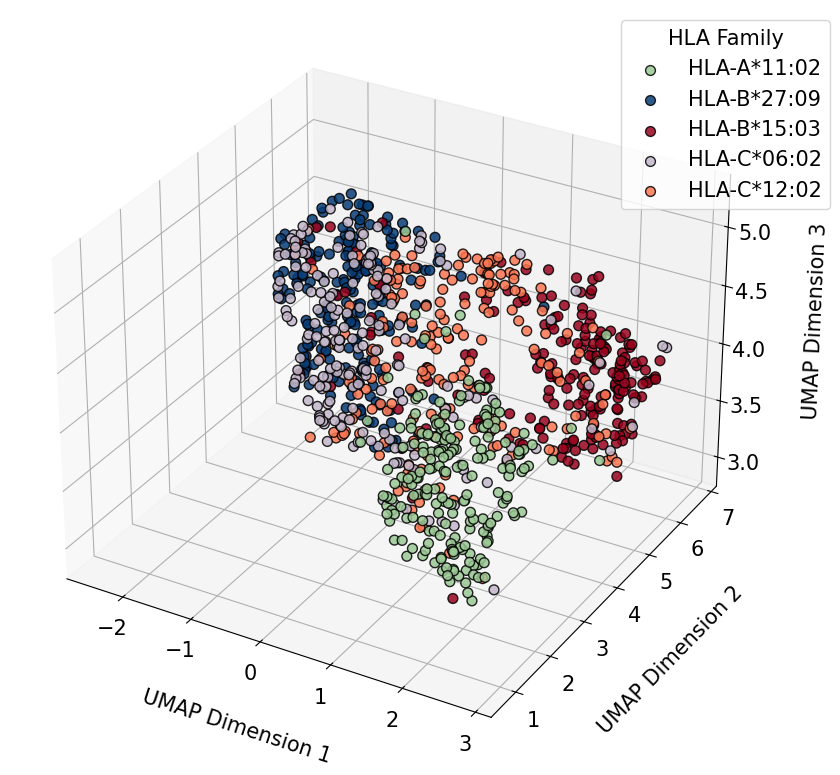

In [130]:
plot_umap_3d(decoderUmap3d,labelsSmallHla,  title= "UMAP of Final Encoder Output:\nPeptide Embeddings by HLA Family")

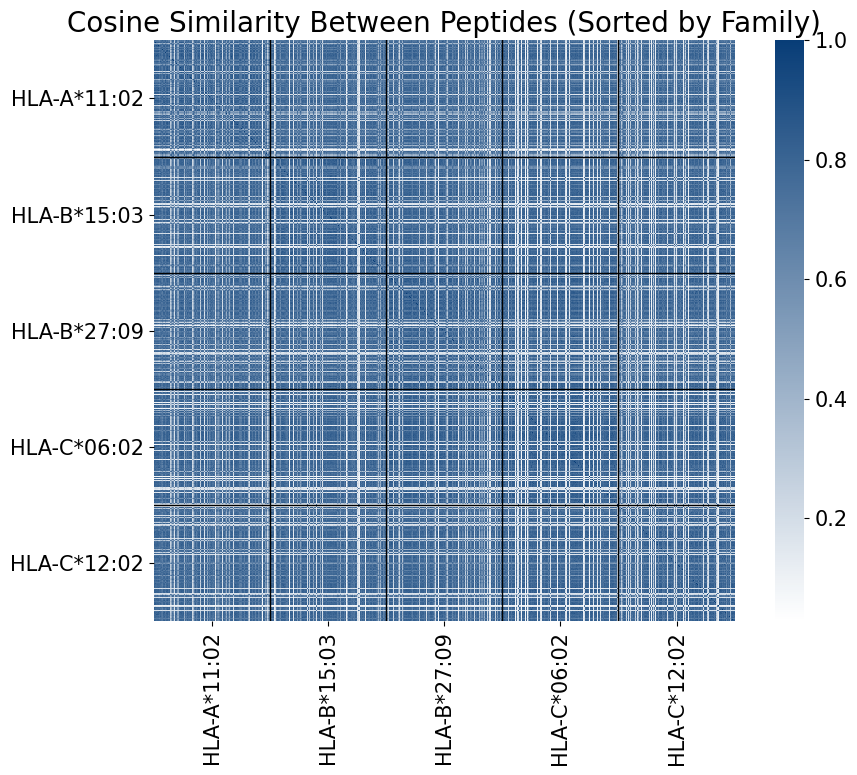

In [131]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import LinearSegmentedColormap

# Encode labels to numeric for sorting
labelEncoder = LabelEncoder()
labelIds = labelEncoder.fit_transform(labelsSmallHla)
sortedIndices = np.argsort(labelIds)

# Step 2: Sort embeddings and labels
embeddingsSorted = pepEncoderOutputs[sortedIndices]
labelsSorted = np.array(labels)[sortedIndices]
labelIdsSorted = labelIds[sortedIndices]

# Step 3: Compute cosine similarity matrix
simMatrix = cosine_similarity(embeddingsSorted)
adjustedSim = np.power(simMatrix, 5)

# Step 4: Plot heatmap with family boundaries
plt.figure(figsize=(10, 8))
white_blue = LinearSegmentedColormap.from_list("white_blue", ["white",  "#083D77"])
sns.heatmap(adjustedSim, cmap=white_blue, square=True, xticklabels=False, yticklabels=False)
plt.title("Cosine Similarity Between Peptides (Sorted by Family)")

# Step 5: Draw lines to show family boundaries
familySizes = np.bincount(labelIdsSorted)
boundaryPositions = np.cumsum(familySizes)

# Use LabelEncoder's classes (sorted unique labels) instead of unique from labelsSorted
uniqueLabels = labelEncoder.classes_

# Compute midpoints for label placement on axes
startIndices = np.insert(boundaryPositions[:-1], 0, 0)
endIndices = boundaryPositions
midpoints = (startIndices + endIndices) // 2

plt.xticks(midpoints, uniqueLabels, rotation=90)
plt.yticks(midpoints, uniqueLabels)

# Draw boundary lines
for pos in boundaryPositions[:-1]:  # skip the last position
    plt.axhline(pos, color='black', linewidth=1)
    plt.axvline(pos, color='black', linewidth=1)

plt.tight_layout()
plt.show()
